# Detection of Image-Scaling Attacks

Image scaling is an integral part of machine learning and computer vision systems. Unfortunately, this preprocessing step is vulnerable to so-called image-scaling attacks, a recent threat that enables an adversary to freely manipulate scaled images. While effective techniques exist to prevent these attacks, their detection has not been
rigorously studied yet. Consequently, it is currently not possible to reliably spot these attacks in practice. In our ACSAC paper, we present the first in-depth systematization and analysis of detection methods for image-scaling attacks. We identify two general detection paradigms and derive novel methods from them that are simple in
design yet significantly outperform previous work. We demonstrate the efficacy of these methods in a comprehensive evaluation with all major learning platforms and scaling algorithms.

The provided repository contains the source code for all developed/evaluated detection methods as well as adaptive attacks against the detection methods. This notebook provides a tutorial how you can 
- a) create an image-scaling attack (modifying the full image or only a local area), 
- b) use the detection methods, and 
- c) apply adaptive attacks against the detection methods. 

## Imports
First, let us load everything we need (a) for the attack, (b) for the detection, and (c) to set up the different experiments here.

In [1]:
from utils.plot_image_utils import plot_images_in_actual_size

from scaling.ScalingGenerator import ScalingGenerator
from scaling.SuppScalingLibraries import SuppScalingLibraries
from scaling.SuppScalingAlgorithms import SuppScalingAlgorithms
from scaling.ScalingApproach import ScalingApproach
from attack.QuadrScaleAttack import QuadraticScaleAttack
from attack.ScaleAttackStrategy import ScaleAttackStrategy
from utils.load_image_data import load_image_examples, load_color_image_example_from_disk

In [2]:
from defenses.detection.DetectionDefense import DetectionDefense
from defenses.detection.DetectionTypeDefense import DetectionTypeDefense
from defenses.detection.DetectionDefenseGenerator import DetectionDefenseGenerator

In [3]:
from defenses.detection.frequency.spectrum.utils import f_utils
from utils.SimilarityMeasure import SimilarityMeasure
from defenses.detection.downandup.HistogramScatteringDefense import UsenixDefenseChoice
from defenses.prevention.PreventionDefenseType import PreventionTypeDefense
from utils.SimilarityMeasurementToolPatchBased import PatchMethod
from defenses.detection.fourier.FourierPeakMatrixCollector import FourierPeakMatrixCollector, PeakMatrixMethod

## Attack
To evaluate the defenses, we first need to run an image-scaling attack. We begin with the global-modification scenario where the downscaled image is completely arbitrary. In this tutorial, we use a simple example where an image-scaling attack modifies an image showing a coffee cup so that it becomes a cat after downscaling. 

In the following, we load two image examples, define the scaling algorithm and library (for simplicity, we use Nearest Scaling from TensorFlow) and define a scaling approach (which saves the scaling setup, incl. the algorithm, library, input size, and output size). *Note: Make sure that you define an own scaling approach for every source-target pair if the scaling ratio changes*. 

Finally, we define and run the attack. This may take a few seconds for the example here. Note that this attack can take more time for larger images. 

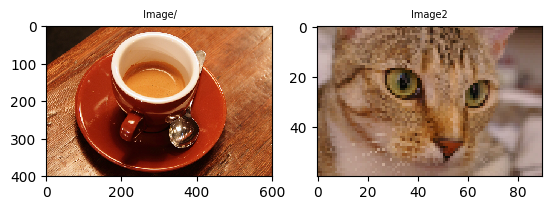

In [4]:
src_image_example, tar_image_example = load_image_examples(img_src=2)

In [5]:
# Define wanted scaling algorithm and library (use enum to get the supported variations)
scaling_algorithm: SuppScalingAlgorithms = SuppScalingAlgorithms.NEAREST
scaling_library: SuppScalingLibraries = SuppScalingLibraries.TF

# Define a scaling approach that saves the scaling setup
scaler_approach: ScalingApproach = ScalingGenerator.create_scaling_approach(
    x_val_source_shape=src_image_example.shape,
    x_val_target_shape=tar_image_example.shape,
    lib=scaling_library,
    alg=scaling_algorithm
)

# Now define and run the image-scaling attack
scale_att: ScaleAttackStrategy = QuadraticScaleAttack(eps=1, verbose=True)

result_attack_image, _, _ = scale_att.attack(src_image=src_image_example,
                                             target_image=tar_image_example,
                                             scaler_approach=scaler_approach)

# Now we use the attack image and scale it down, as we would do in a real machine learning pipeline.
result_output_image = scaler_approach.scale_image(xin=result_attack_image)

2023-08-24 10:55:54.172053: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-08-24 10:55:54.183758: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2803200000 Hz
2023-08-24 10:55:54.184407: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0xeb7560 executing computations on platform Host. Devices:
2023-08-24 10:55:54.184422: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


Channel: 0
Iteration: 0
Iteration: 20
Iteration: 40
Iteration: 60
Iteration: 80
Iteration: 0
Iteration: 20
Iteration: 40
Iteration: 60
Iteration: 80
Iteration: 100
Iteration: 120
Iteration: 140
Iteration: 160
Iteration: 180
Iteration: 200
Iteration: 220
Iteration: 240
Iteration: 260
Iteration: 280
Iteration: 300
Iteration: 320
Iteration: 340
Iteration: 360
Iteration: 380
Channel: 1
Iteration: 0
Iteration: 20
Iteration: 40
Iteration: 60
Iteration: 80
Iteration: 0
Iteration: 20
Iteration: 40
Iteration: 60
Iteration: 80
Iteration: 100
Iteration: 120
Iteration: 140
Iteration: 160
Iteration: 180
Iteration: 200
Iteration: 220
Iteration: 240
Iteration: 260
Iteration: 280
Iteration: 300
Iteration: 320
Iteration: 340
Iteration: 360
Iteration: 380
QSQP failed
Channel: 2
Iteration: 0
Iteration: 20
Iteration: 40
Iteration: 60
Iteration: 80
Iteration: 0
Iteration: 20
Iteration: 40
Iteration: 60
Iteration: 80
Iteration: 100
Iteration: 120
Iteration: 140
Iteration: 160
Iteration: 180
Iteration: 200
I

Let's plot the images. A succesful attack is characterized by two goals:

    O1: The downscaled attack image should correspond to the target image
    O2: The attack image should correspond to the original source image
    
Let's start with the images before scaling (goal O2). In the following, you see the original image on the left, and the attack image on the right.

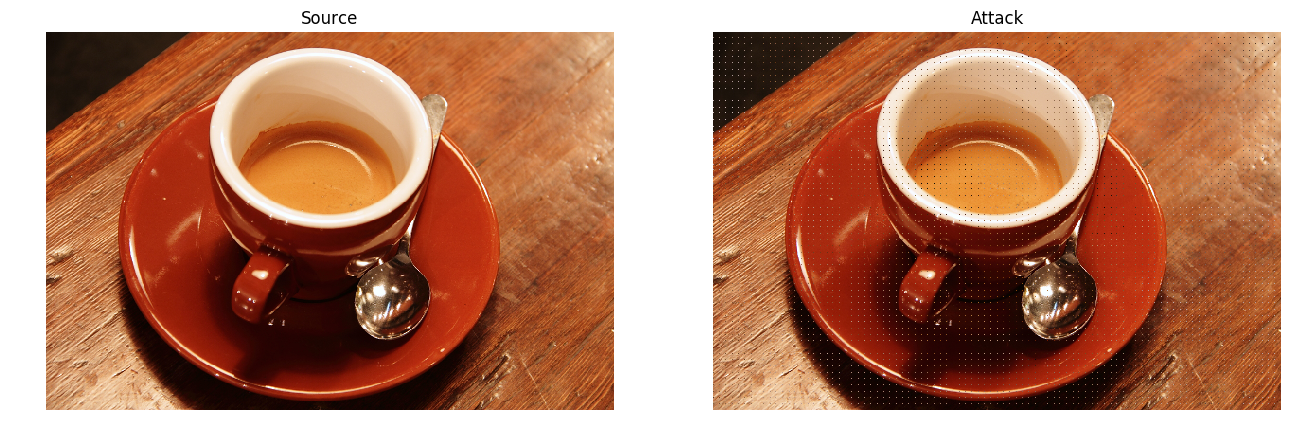

In [6]:
plot_images_in_actual_size(imgs=[src_image_example, result_attack_image], titles=["Source", "Attack"], rows=1)

The attack image looks like the source image. No obvious traces of an attack!

Now let's check what happens after scaling.

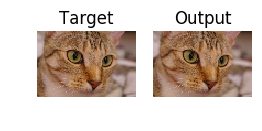

In [7]:
plot_images_in_actual_size(imgs=[tar_image_example, result_output_image], titles=["Target", "Output"], rows=1)

The output image of downscaling (on the right) is *not* a smaller version of the coffee mug, as we would expect. We obtain a cat, exactly as the target image. We thus achieve goal O1. This output image would be used by neural networks or another systems, allowing novel attacks to mislead classifiers or to perform poisoning attacks.

## Defense: Detection Methods
The ACSAC paper comprehensively analyzes various detection methods to spot image-scaling attacks. 

Let's look at the following table which is just an extended version of Table 1 in the paper. The following table outlines the different detection methods, grouped by the paradigm. Some methods have multiple options. For example, if we down-and-upscale an attack image, we can compare the original and down-upscaled image by using PSNR, MSE, some histogram-based comparison, or other methods. As prior work has proposed different comparison methods, we evaluate all options.  

We will now evaluate every detection approach (= each row) in this table.

| Paradigm  | Paradigm-2                | Method                      | Options                 |
|:-----------|:---------------------------|:-----------------------------|:-------------------------|
| Frequency |                           | Peak Spectrum               | --                      |
|           |                           | Peak Distance               | --                      |
|           |                           | CSP                         | --                      |
|           |                           | CSP-improved                | --                      |
| Spatial   | Adversarial-Signal-Driven | Down & Upscaling            | PSNR                    |
|           |                           | Down & Upscaling            | Histogram               |
|           |                           | Down & Upscaling            | Color-Scattering        |
|           |                           | Down & Upscaling            | MSE                     |
|           |                           | Down & Upscaling            | SSIM                    |
|           |                           | Maximum Filter              | MSE                     |
|           |                           | Maximum Filter              | SSIM                    |
|           |                           | Minimum Filter              | MSE                     |
|           |                           | Minimum Filter              | SSIM                    |
|           | Clean-Signal Driven       | Clean Filter                | Median filtering + PSNR |
|           |                           | Clean Filter                | Median filtering + SSIM |
|           |                           | Clean Filter                | Random filtering + PSNR |
|           |                           | Clean Filter                | Random filtering + SSIM |
|           |                           | Patch-Clean Filter          | --                      |
|           |                           | Targeted Patch-Clean Filter | --                      |

**Note**: In this tutorial, we instantiate all detection methods with the best hyperparameters (determined on a seperate validation dataset during the evaluation). These hyperparameters were used to generate the results on the test set that are presented in the different tables in Section 4 and 5.

**Remark**: These hyperparameters were derived from the dataset based on ImageNet. If you have a different image distribution, you should run a new hyperparameter search to find the best parameters for your dataset. Please look at the appendix in this tutorial for more details on the hyperparameters of the detection methods.

**Code**:
Using the *DetectionDefenseGenerator*, every detection method can be simply generated by specifying the wanted defense as *enum* and the *defense parameters as dictionary*. You always get a defense object of the class *DetectionDefense* (think of it more like an interface), so that you have a fixed way of interacting with each defense method. 

**Eval Function**: To evaluate the detection methods in this notebook, let us define a small helper function that creates a defense method and evaluates it on the attack & original image.

In [8]:
def eval_defense(args_defense_method: DetectionTypeDefense, att_image, kwargs_detection_method: dict):

    detection_defense: DetectionDefense = DetectionDefenseGenerator.create_detection_defense(
        defense_type=args_defense_method,
        verbose_flag=False,
        scaler_approach=scaler_approach,
        **kwargs_detection_method)

    score_a, _ = detection_defense.detect_attack(att_image=att_image)
    print(f"{args_defense_method.name}: Attack Image Score: {score_a}")
    score_b, _ = detection_defense.detect_attack(att_image=src_image_example)
    print(f"{args_defense_method.name}: Benign Image Score: {score_b}")


*Short Explanation*
- We use a DetectionDefenseGenerator that generates each detection method.
- Every detection method is of type *DetectionDefense* so that you have a fixed API for all detection defenses.
- We pass an enum that defines the defense, and different hyperparameters as dictionary. See below which parameters are needed for each defense.

## Detection in Global-Modification Scenario
In this section, we use the detection methods that were presented in **Section 3** in the paper. In the following, we will focus on the global-modification scenario (source and target image are arbitrary). This scenario has been evaluated in **Section 4.2**.

### A. Frequency Paradigm
The frequency paradigm exploits that image-scaling attacks will leave characteristic traces in the frequency spectrum. Before looking at the detection methods, let's look at the frequency spectrum of our attack image and the original image.

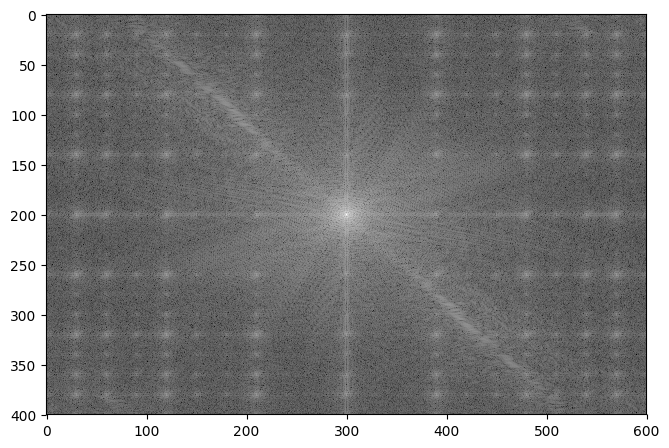

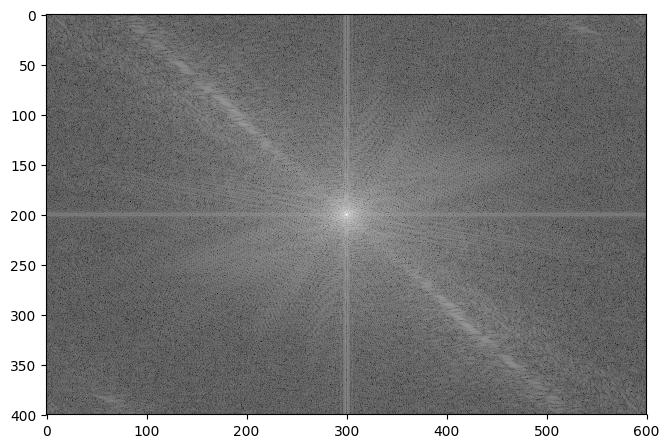

In [9]:
from defenses.detection.frequency.spectrum.utils.f_utils import fourier
from utils.plot_image_utils import plot_images1_actual_size
plot_images1_actual_size(fourier(result_attack_image))
plot_images1_actual_size(fourier(src_image_example))

In the first image (the attack image), you can clearly see the different frequency peaks that the attack causes (like Figure 4 in the paper shows). On the contrary, the second image (the original image) has no peaks. 

*Remark*: Of course, benign images can have natural peaks too, but they usually do not occur where peaks occur if an image-scaling attack happens. Thus, the defender can compute where adversarial peaks would be located and check if the peaks from an image under investigation match with these expected peak locations. The proposed frequency methods (Peak Spectrum and Peak Distance) use this insight.

Okay, now let's proceed with the detection methods.

In [10]:
# 1. Peak Spectrum
eval_defense(args_defense_method=DetectionTypeDefense.frequency_spectrum_sampling,
             att_image=result_attack_image,
             kwargs_detection_method={
                 'sampling_radius': 5,
                 'peak_finding_method': f_utils.get_main_peaks,
             })

# 2. Peak Distance
eval_defense(args_defense_method=DetectionTypeDefense.frequency_spectrum_distance,
             att_image=result_attack_image,
             kwargs_detection_method={})

# 3. CSP
eval_defense(args_defense_method=DetectionTypeDefense.frequency_csp,
             att_image=result_attack_image,
             kwargs_detection_method={'contourmethod': 13})

# 4. CSP-improved
eval_defense(args_defense_method=DetectionTypeDefense.frequency_csp,
             att_image=result_attack_image,
             kwargs_detection_method={'contourmethod': 1})

frequency_spectrum_sampling: Attack Image Score: 89.43708333333333
frequency_spectrum_sampling: Benign Image Score: 55.42166666666667
frequency_spectrum_distance: Attack Image Score: 1.0
frequency_spectrum_distance: Benign Image Score: 31.993129710106007
frequency_csp: Attack Image Score: 0.0
frequency_csp: Benign Image Score: 0.0
frequency_csp: Attack Image Score: 1.0
frequency_csp: Benign Image Score: 1.0


Every method has its own range for the scores. By evaluating the method on different attack images and benign images, we can derive a threshold for each method (not included in this notebook).

### B. Spatial, Adversarial-Signal Driven

In [11]:
# 5. Down & Upscaling with PSNR
eval_defense(args_defense_method=DetectionTypeDefense.downandup,
             att_image=result_attack_image,
             kwargs_detection_method={'similarity_measurement': SimilarityMeasure.PSNR})

# 6. Down & Upscaling with MSE or SSIM (as suggested by Kim et al.)
eval_defense(args_defense_method=DetectionTypeDefense.downandup,
             att_image=result_attack_image,
             kwargs_detection_method={'similarity_measurement': SimilarityMeasure.MSE})
eval_defense(args_defense_method=DetectionTypeDefense.downandup,
             att_image=result_attack_image,
             kwargs_detection_method={'similarity_measurement': SimilarityMeasure.SSIM})

# 7. Down & Upscaling with histogram or color-scattering (as suggested by Xiao et al.)
eval_defense(args_defense_method=DetectionTypeDefense.downandup_histoscattering,
             att_image=result_attack_image,
             kwargs_detection_method={'method': UsenixDefenseChoice.use_histogram})
eval_defense(args_defense_method=DetectionTypeDefense.downandup_histoscattering,
             att_image=result_attack_image,
             kwargs_detection_method={'method': UsenixDefenseChoice.use_scattering})

# 8. Down & Upscaling with maximum or minimum filter (as suggested by Kim et al.)
eval_defense(args_defense_method=DetectionTypeDefense.filtering_min,
             att_image=result_attack_image,
             kwargs_detection_method={'kernel_size': (3, 3),
                                      'similarity_measurement': SimilarityMeasure.MSE})
eval_defense(args_defense_method=DetectionTypeDefense.filtering_max,
             att_image=result_attack_image,
             kwargs_detection_method={'kernel_size': (3, 3),
                                      'similarity_measurement': SimilarityMeasure.MSE})
eval_defense(args_defense_method=DetectionTypeDefense.filtering_min,
             att_image=result_attack_image,
             kwargs_detection_method={'kernel_size': (3, 3),
                                      'similarity_measurement': SimilarityMeasure.SSIM})
eval_defense(args_defense_method=DetectionTypeDefense.filtering_max,
             att_image=result_attack_image,
             kwargs_detection_method={'kernel_size': (3, 3),
                                      'similarity_measurement': SimilarityMeasure.SSIM})

downandup: Attack Image Score: 10.8209285533697
downandup: Benign Image Score: 18.538661441897506
downandup: Attack Image Score: 0.00018578579041111015
downandup: Benign Image Score: 0.0010984638861323548
downandup: Attack Image Score: 0.19389638043776536
downandup: Benign Image Score: 0.4901030976948512
downandup_histoscattering: Attack Image Score: 0.8038886938005355
downandup_histoscattering: Benign Image Score: 0.9859943391359175
downandup_histoscattering: Attack Image Score: 0.8605410471915552
downandup_histoscattering: Benign Image Score: 0.9905989209064976
filtering_min: Attack Image Score: 0.0011516618481268236
filtering_min: Benign Image Score: 0.002120251344842299
filtering_max: Attack Image Score: 0.0008336547023967166
filtering_max: Benign Image Score: 0.0017406878626907507
filtering_min: Attack Image Score: 0.4296701246116175
filtering_min: Benign Image Score: 0.7147966505288075
filtering_max: Attack Image Score: 0.427119506276974
filtering_max: Benign Image Score: 0.73065

### C. Spatial, Clean-Signal Driven

In [12]:
# 9. Clean Filter
fourierpeakmatrixcollector = FourierPeakMatrixCollector(
    method=PeakMatrixMethod.optimization,
    scale_library=scaling_library, scale_algorithm=scaling_algorithm,
)
# The first call will run a few seconds more, as fourierpeakmatrixcollector needs to do some setup
# for the scaling ratio of the image example. It is only necessary one time for every scaling ratio.
eval_defense(args_defense_method=DetectionTypeDefense.filtering_prevention,
             att_image=result_attack_image,
             kwargs_detection_method={
                 'prevention_defense_type': PreventionTypeDefense.medianfiltering,
                 'fourierpeakmatrixcollector': fourierpeakmatrixcollector,
                 'similarity_measurement': SimilarityMeasure.PSNR,
             })
eval_defense(args_defense_method=DetectionTypeDefense.filtering_prevention,
             att_image=result_attack_image,
             kwargs_detection_method={
                 'prevention_defense_type': PreventionTypeDefense.medianfiltering,
                 'fourierpeakmatrixcollector': fourierpeakmatrixcollector,
                 'similarity_measurement': SimilarityMeasure.SSIM,
             })
eval_defense(args_defense_method=DetectionTypeDefense.filtering_prevention,
             att_image=result_attack_image,
             kwargs_detection_method={
                 'prevention_defense_type': PreventionTypeDefense.medianfiltering,
                 'fourierpeakmatrixcollector': fourierpeakmatrixcollector,
                 'similarity_measurement': SimilarityMeasure.PSNR,
             })
eval_defense(args_defense_method=DetectionTypeDefense.filtering_prevention,
             att_image=result_attack_image,
             kwargs_detection_method={
                 'prevention_defense_type': PreventionTypeDefense.randomfiltering,
                 'fourierpeakmatrixcollector': fourierpeakmatrixcollector,
                 'similarity_measurement': SimilarityMeasure.SSIM,
             })

# 10. Patch-Clean Filter
eval_defense(args_defense_method=DetectionTypeDefense.filtering_patch_prevention_block,
             att_image=result_attack_image,
             kwargs_detection_method={
                 'patch_method': PatchMethod.use_block_based,
                 'patch_comparison_params': {'window_factor': 5,
                                             'step_size_factor': 4},
                 'prevention_defense_type': PreventionTypeDefense.medianfiltering,
                 'fourierpeakmatrixcollector': fourierpeakmatrixcollector,
                 'similarity_measurement': SimilarityMeasure.PSNR,
             })
# 11. Targeted Patch-Clean Filter
eval_defense(args_defense_method=DetectionTypeDefense.filtering_targeted_patch_prevention_block,
             att_image=result_attack_image,
             kwargs_detection_method={
                 'patch_method': PatchMethod.use_block_based,
                 'patch_comparison_params': {'window_factor': 10,
                                             'step_size_factor': 2 },
                 'quantile_value': 0.6,
                 'prevention_defense_type': PreventionTypeDefense.medianfiltering,
                 'fourierpeakmatrixcollector': fourierpeakmatrixcollector,
             })

filtering_prevention: Attack Image Score: 27.399201717480615
filtering_prevention: Benign Image Score: 40.38742056271098
filtering_prevention: Attack Image Score: 0.7221522950178499
filtering_prevention: Benign Image Score: 0.9937681710871354
filtering_prevention: Attack Image Score: 27.399201717480615
filtering_prevention: Benign Image Score: 40.38742056271098
filtering_prevention: Attack Image Score: 0.7204052573587485
filtering_prevention: Benign Image Score: 0.9770239534319533
filtering_patch_prevention_block: Attack Image Score: 5.477844478395898
filtering_patch_prevention_block: Benign Image Score: 8.075598050843787
filtering_targeted_patch_prevention_block: Attack Image Score: 96.946
filtering_targeted_patch_prevention_block: Benign Image Score: 23.140666666666668


## Detection in Local-Modification Scenario

Okay, now let's proceed with a small example how we can detect local modifications. To this end, let's first define a small, simple backdoor that is added to every image.

### Image-Scaling Attack in Local Scenario 

In [13]:
backd_size = 15
scaled_image = scaler_approach.scale_image(xin=src_image_example)

scaled_image[scaled_image.shape[0]-backd_size-2 : (scaled_image.shape[0]-2), 2:(backd_size+2)] = (scaled_image[scaled_image.shape[0]-backd_size-2 : (scaled_image.shape[0]-2), 2:(backd_size+2)] * 0.1) + (1-0.1)

We can see the backdoor (it is just a small black square in the lower-left corner) if we plot the image.

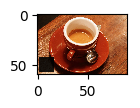

In [14]:
plot_images1_actual_size(scaled_image)

In [15]:
# Perform scaling attack with backdoored image as downscaled image, and original image as source image
scale_att: QuadraticScaleAttack = QuadraticScaleAttack(eps=1, verbose=True)

result_attack_image_local, _, _ = scale_att.attack(src_image=src_image_example,
                                                                target_image=scaled_image,
                                                                scaler_approach=scaler_approach)
result_output_image_local = scaler_approach.scale_image(xin=result_attack_image_local)

Channel: 0
Iteration: 0
Iteration: 20
Iteration: 40
Iteration: 60
Iteration: 80
Iteration: 0
Iteration: 20
Iteration: 40
Iteration: 60
Iteration: 80
Iteration: 100
Iteration: 120
Iteration: 140
Iteration: 160
Iteration: 180
Iteration: 200
Iteration: 220
Iteration: 240
Iteration: 260
Iteration: 280
Iteration: 300
Iteration: 320
Iteration: 340
Iteration: 360
Iteration: 380
Channel: 1
Iteration: 0
Iteration: 20
Iteration: 40
Iteration: 60
Iteration: 80
Iteration: 0
Iteration: 20
Iteration: 40
Iteration: 60
Iteration: 80
Iteration: 100
Iteration: 120
Iteration: 140
Iteration: 160
Iteration: 180
Iteration: 200
Iteration: 220
Iteration: 240
Iteration: 260
Iteration: 280
Iteration: 300
Iteration: 320
Iteration: 340
QSQP failed
Iteration: 360
Iteration: 380
Channel: 2
Iteration: 0
Iteration: 20
Iteration: 40
Iteration: 60
Iteration: 80
Iteration: 0
Iteration: 20
Iteration: 40
Iteration: 60
Iteration: 80
Iteration: 100
Iteration: 120
Iteration: 140
Iteration: 160
Iteration: 180
Iteration: 200
I

Now we can plot the attack image where you will see a slight perturbation of the backdoor on the left. This perturbation becomes the backdoor after scaling (see second image)

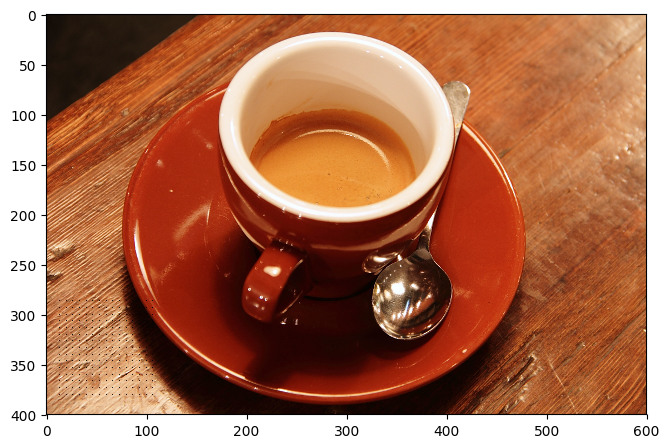

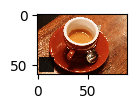

In [16]:
plot_images1_actual_size(result_attack_image_local)
plot_images1_actual_size(result_output_image_local)

### Detection
The detection of image-scaling attacks that only modify a local image area is challenging. In the following, we apply the detection methods on the backdoored example above---like the paper did in **Section 4.3**. 

The paper shows that only specific methods are effective here (see Table 5 in the paper). Only the proposed frequency-based methods are highly effective. The patch-based methods are also effective. The remaining methods are not able to detect the attacks. The methods in the spatial paradigm, for example, are not effective anymore because scaling attacks change only a small area. Thus, many of the compared areas still correspond to the original image, making a comparison difficult. 

Let's take a look on some detection methods in this tutorial (to keep the tutorial short, we will just consider a few examples in the following).
We begin with our frequency methods:

In [17]:
# 1. Peak Spectrum
eval_defense(args_defense_method=DetectionTypeDefense.frequency_spectrum_sampling,
             att_image=result_attack_image_local,
             kwargs_detection_method={
                 'sampling_radius': 5,
                 'peak_finding_method': f_utils.get_main_peaks,
             })

# 2. Peak Distance
eval_defense(args_defense_method=DetectionTypeDefense.frequency_spectrum_distance,
             att_image=result_attack_image_local,
             kwargs_detection_method={})

frequency_spectrum_sampling: Attack Image Score: 79.2
frequency_spectrum_sampling: Benign Image Score: 55.42166666666667
frequency_spectrum_distance: Attack Image Score: 10.350505803836407
frequency_spectrum_distance: Benign Image Score: 31.993129710106007


We can see that there is a clear distinction between attack and benign images. Let's check how down-and-upscaling (a spatial-paradigm method) works.

In [18]:
eval_defense(args_defense_method=DetectionTypeDefense.downandup,
             att_image=result_attack_image_local,
             kwargs_detection_method={'similarity_measurement': SimilarityMeasure.SSIM})

downandup: Attack Image Score: 0.48429265378156633
downandup: Benign Image Score: 0.4901030976948512


The values are very close to each other (not comparable with the global scenario). This will make a distinction difficult, and leads to the poor performance as reported in Table 5.

## Adaptive Attacks
If we develop defenses, we also have to think about adaptive attacks, that is, how can the attacker adjust the strategy to bypass a particular defense. In **Section 5** of the paper, three attack types have been evaluated.
1. Suppressing Frequency / Disabling Frequency
2. Add Frequency Peak
3. JPEG Compression (our baseline)

In [19]:
from attack.adaptive_attack.detection.AdaptiveAttackDetectionGenerator import AdaptiveAttackDetectionGenerator
from attack.adaptive_attack.AdaptiveAttack import AdaptiveAttackOnAttackImage2
from attack.adaptive_attack.detection.AdaptiveDetectionStrategy import AdaptiveDetectionStrategy

You can choose the attack strategy by using the Enum definition.

In [20]:
AdaptiveDetectionStrategy.jpeg
AdaptiveDetectionStrategy.disable_frequencies
AdaptiveDetectionStrategy.add_frequency_peak

<AdaptiveDetectionStrategy.add_frequency_peak: 3>

Every adaptive attack has different parameters.
- The main parameter for disabling frequencies is "disabling_factor" (parameter f_s in the paper).
- The main parameter for adding peaks is "frequency_modification_factor" (parameter f_a in the paper).

In [21]:
kwargs_adaptive_method_jpeg = {
    'quality_factor': 90
}
kwargs_adaptive_method_disable_frequencies = {
    'disabling_factor': 0.6,
    'sampling_radius_attack': 5,
    'peak_finding_method': f_utils.get_main_peaks,
    'sampling_radius_defense': 5, 
}
kwargs_adaptive_method_add_frequency_peak = {
    'frequency_modification_factor': 50
}

Let's run an adaptive attack against one of the frequency methods.

In [22]:
# Let's try the add-frequency-peak attack against Peak Distance in the global-modification scenario
# 1. Definitions
# Our defense is:
args_defense_method = DetectionTypeDefense.frequency_spectrum_distance
kwargs_detection_method = {}

# Our adaptive attack is:
args_adaptive_method = AdaptiveDetectionStrategy.add_frequency_peak
kwargs_adaptive_method_add_frequency_peak = {
    'frequency_modification_factor': 50
}

# 2. Run Adaptive Attack
adaptive_attack: AdaptiveAttackOnAttackImage2 = AdaptiveAttackDetectionGenerator.create_adaptive_attack(
        attack_type=args_adaptive_method,
        verbose_flag=False,
        scaler_approach=scaler_approach,
        **kwargs_adaptive_method_add_frequency_peak)
adaptive_attack_image, _ = adaptive_attack.counter_attack(att_image=result_attack_image,
                                                           src=src_image_example,
                                                           tar=tar_image_example)
downscl_adaptive_attack_image = scaler_approach.scale_image(xin=adaptive_attack_image)

# 3. Detection of Adaptive Attack
detection_defense: DetectionDefense = DetectionDefenseGenerator.create_detection_defense(defense_type=args_defense_method,
                                                                                         verbose_flag=False,
                                                                                         scaler_approach=scaler_approach,
                                                                                         **kwargs_detection_method)

score_out, _ = detection_defense.detect_attack(att_image=adaptive_attack_image)
print(score_out)

score_out_before, _ = detection_defense.detect_attack(att_image=result_attack_image)
print(score_out_before)
score_out_benign, _ = detection_defense.detect_attack(att_image=src_image_example)
print(score_out_benign)

45.24615959110455
1.0
31.993129710106007


We can see that the adaptive attack has increased the score substantially. It is now closer to the score that we get for the benign image. This will make the detection more challenging, as reported in the paper. 

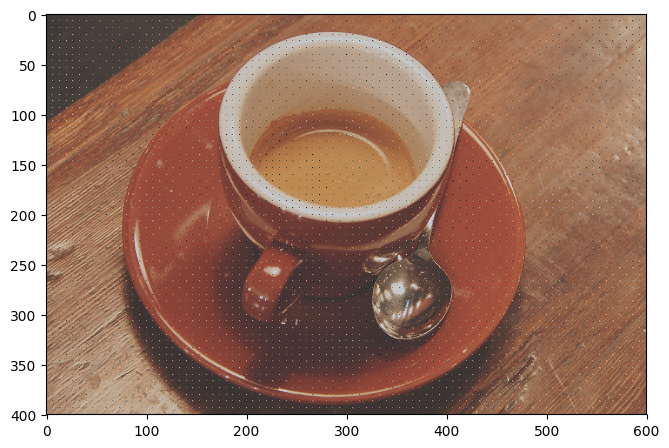

In [27]:
# Let's plot the adaptive attack image. 
# The effect of the adaptive manipulation to bypass the detection is visible, but the image quality is still okay. 
plot_images1_actual_size(adaptive_attack_image)

## Summary
This notebook shows 
- how to implement a standard image-scaling attack.
- how to use the different detection methods.
- how to apply adaptive attacks against the detection methods.

## Appendix Hyperparameters
Some detection methods have hyperparameters that need to be set depending on a validation dataset. In the following, we will see which methods have hyperparameters and which values can be tested. Note that we simply did a grid search on possible values, but of course, you can perform a more advanced method to select hyperparameters and test more possible values.

But first, the following methods have hyperparameters:
- Peak Spectrum
    - Tested values in our grid-search were:
        - Sampling Radius: 5, 10, 20
- Patch Clean Filter
    - Tested values in our grid-search were:
        - Window Factor: 3, 5, 10
        - Step Size Factor: 2, 4
- Targeted Patch-Clean Filter
    - Tested values in our grid-search were:
        - Quantile: 0.5, 0.6, 0.7, 0.8, 0.9
        - Window Factor: 3, 5, 10
        - Step Size Factor: 2, 4

Let's get that in code. In the following, we define a dictionary for each method that contains a list of tested values for each parameter.

In [24]:
params = {}
#### Peak Spectrum
params[DetectionTypeDefense.frequency_spectrum_sampling] = {
        'sampling_radius': [5, 10, 20]
}
# Note that Peak Spectrum also allows you to set the 'peak_finding_method' parameter. 
# You can set [get_main_peaks,get_main_and_secondary_peaks]. 
# However, get_main_and_secondary_peaks did not lead to improvements in our experiments.

#### Patch Clean Filter
params[DetectionTypeDefense.filtering_patch_prevention_block] = {
        'patch_comparison_params': {'window_factor': [3, 5, 10],
                                    'step_size_factor': [2, 4]
                                   },
        # the following are rather fixed
        'similarity_measurement': SimilarityMeasure.PSNR,  
        'patch_method': PatchMethod.use_block_based,  
        'prevention_defense_type': PreventionTypeDefense.medianfiltering,  
}

#### Targeted Patch Clean Filter
params[DetectionTypeDefense.filtering_targeted_patch_prevention_block] = {
        'quantile_value': [0.5, 0.6, 0.7, 0.8, 0.9],
        'patch_comparison_params': {'window_factor': [3, 5, 10],
                                    'step_size_factor': [2, 4]
                                   },    
        'patch_method': PatchMethod.use_block_based,  
        'prevention_defense_type': PreventionTypeDefense.medianfiltering,  
}

You can use this dictionary to get all possible combinations of hyperparameters (not included in this tutorial).

In [25]:
# Note: To translate the window factor and step_size_factor into a readable window size and stride 
# as used in the paper, just use the following code:
from utils.SimilarityMeasurementToolPatchBased import compute_block_stride_size_from_factors

window_shape, stride = compute_block_stride_size_from_factors(image_shape=tar_image_example.shape,  # (224, 224) in our experiments with VGG19
                                      window_factor=10, step_size_factor=4)  # example: 10 and 4 as factors
print("Window w =", window_shape[0]/2, "Stride s =", stride)

Window w = 3.0 Stride s = 1
